Cell 1: Imports and Data Loading (The Foundation)
This cell imports all necessary libraries and loads/pre-processes the raw corpus data. The N-gram training happens immediately after loading the corpus.

In [1]:
# Cell 1: Imports, Global Definitions, and Data Preparation

import string
import re
import random
import pickle
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# The set of all valid letters
ALPHABET = set(string.ascii_lowercase)
# Fallback letter frequency, will be updated after N-gram training
GENERIC_LETTERS = "etaoinsrhldcumfpgwybvkxjqz"

def load_and_clean_corpus(corpus_file="./data/Data/corpus.txt"):
    """ Loads the corpus, cleans it, and groups words by length. """
    words_by_length = defaultdict(list)
    word_set = set()
    
    print(f"Loading and cleaning {corpus_file}...")
    
    try:
        with open(corpus_file, 'r', encoding='utf-8', errors='ignore') as f:
            words = f.read().split()
    except FileNotFoundError:
        print(f"ERROR: {corpus_file} not found.")
        return None, None

    cleaned_count = 0
    for word in words:
        cleaned_word = word.lower()
        if all(char in ALPHABET for char in cleaned_word) and len(cleaned_word) > 1:
            words_by_length[len(cleaned_word)].append(cleaned_word)
            word_set.add(cleaned_word)
            cleaned_count += 1
            
    print(f"Load complete. Found {cleaned_count} valid words grouped by length.")
    return words_by_length, list(word_set)

def train_ngram_models(word_list):
    """ Trains unigram, bigram, and trigram models from the word list. """
    print("Training N-gram models...")
    unigram_counts = defaultdict(int)
    bigram_counts = defaultdict(lambda: defaultdict(int))
    trigram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    total_letters = 0
    
    for word in word_list:
        padded_word = ['#', '#'] + list(word) + ['#']
        for i in range(2, len(padded_word)):
            p1, p2, char = padded_word[i-2], padded_word[i-1], padded_word[i]
            if char != '#':
                unigram_counts[char] += 1
                total_letters += 1
            bigram_counts[p2][char] += 1
            trigram_counts[p1][p2][char] += 1

    # Normalize
    unigram_probs = {char: count / total_letters for char, count in unigram_counts.items()}
    bigram_probs = defaultdict(lambda: defaultdict(float))
    for p2, chars in bigram_counts.items():
        total = sum(chars.values())
        for char, count in chars.items():
            bigram_probs[p2][char] = count / total
            
    trigram_probs = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    for p1, p2s in trigram_counts.items():
        for p2, chars in p2s.items():
            total = sum(chars.values())
            for char, count in chars.items():
                trigram_probs[p1][p2][char] = count / total
                
    print("N-gram training complete.")
    
    sorted_unigrams = sorted(unigram_probs.items(), key=lambda item: item[1], reverse=True)
    corpus_generic_letters = "".join([char for char, prob in sorted_unigrams])
    
    return {
        'unigrams': unigram_probs,
        'bigrams': bigram_probs,
        'trigrams': trigram_probs,
        'generic_letters': corpus_generic_letters
    }

# --- EXECUTE DATA LOADING AND N-GRAM TRAINING ---
all_words_by_length, all_words_list = load_and_clean_corpus("./data/Data/corpus.txt")

if all_words_list:
    ngram_models = train_ngram_models(all_words_list)
    GENERIC_LETTERS = ngram_models['generic_letters']
    print(f"New corpus-trained generic letter order: {GENERIC_LETTERS}")
else:
    print("No words loaded, skipping N-gram training.")
    ngram_models = {}

Loading and cleaning ./data/Data/corpus.txt...
Load complete. Found 49975 valid words grouped by length.
Training N-gram models...
N-gram training complete.
New corpus-trained generic letter order: eiaorntslcupmdhygbfvkwzxqj


Cell 2: Exploratory Data Analysis (EDA) (The Insight)
This cell runs the EDA code before training, establishing the statistical foundation for the HMM and fallback mechanisms.


--- 1. EDA: Word Length Distribution ---


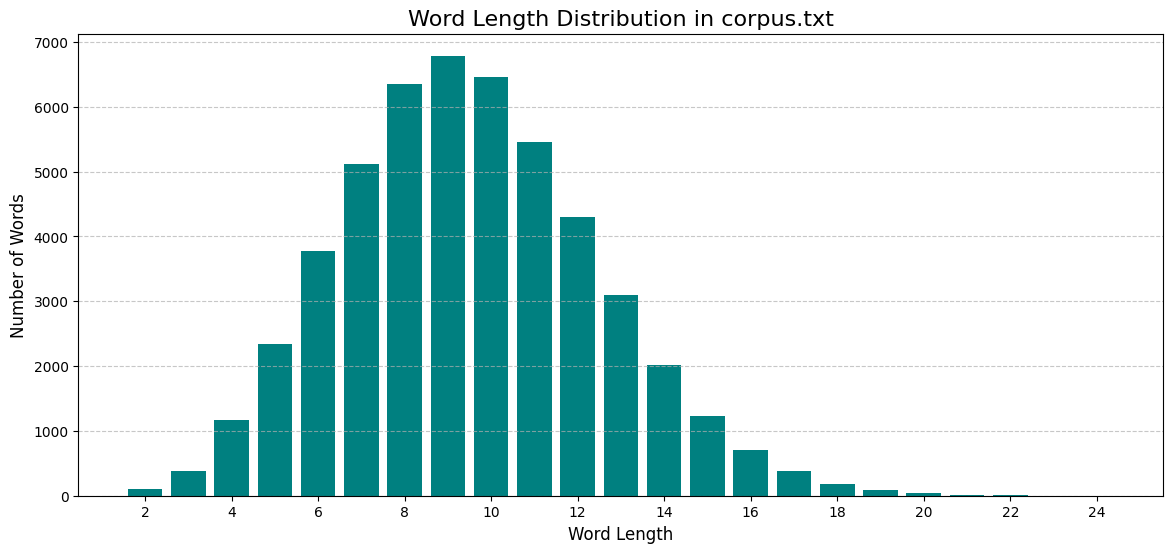


--- 2. EDA: Overall Letter Frequency ---


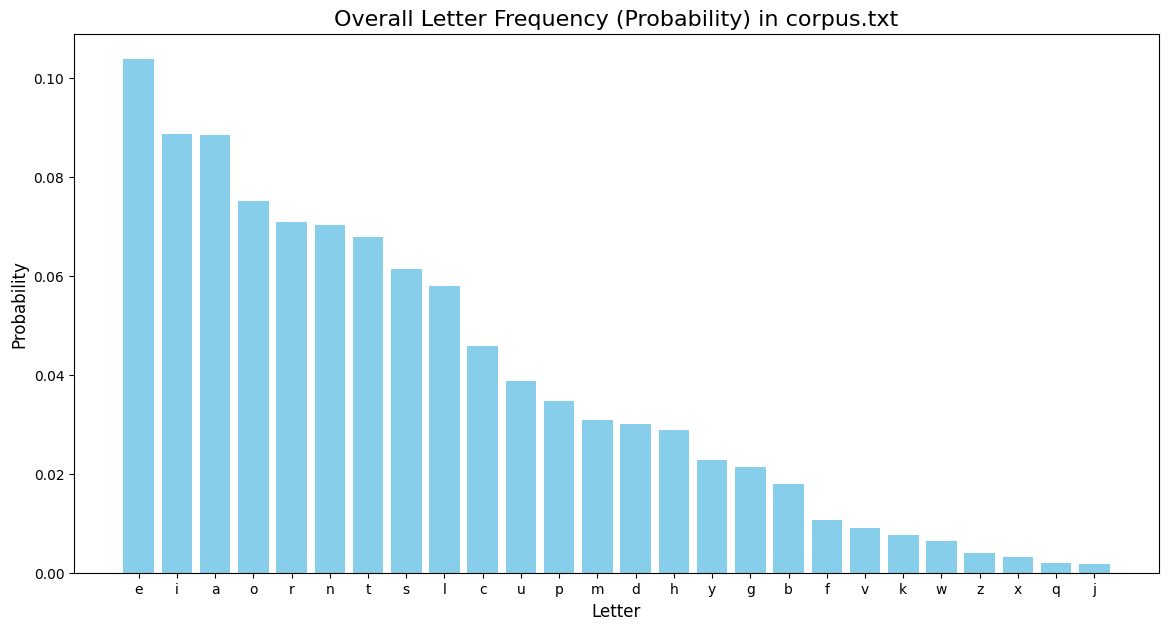


--- 3. EDA: Positional Letter Frequency (Heatmap) ---


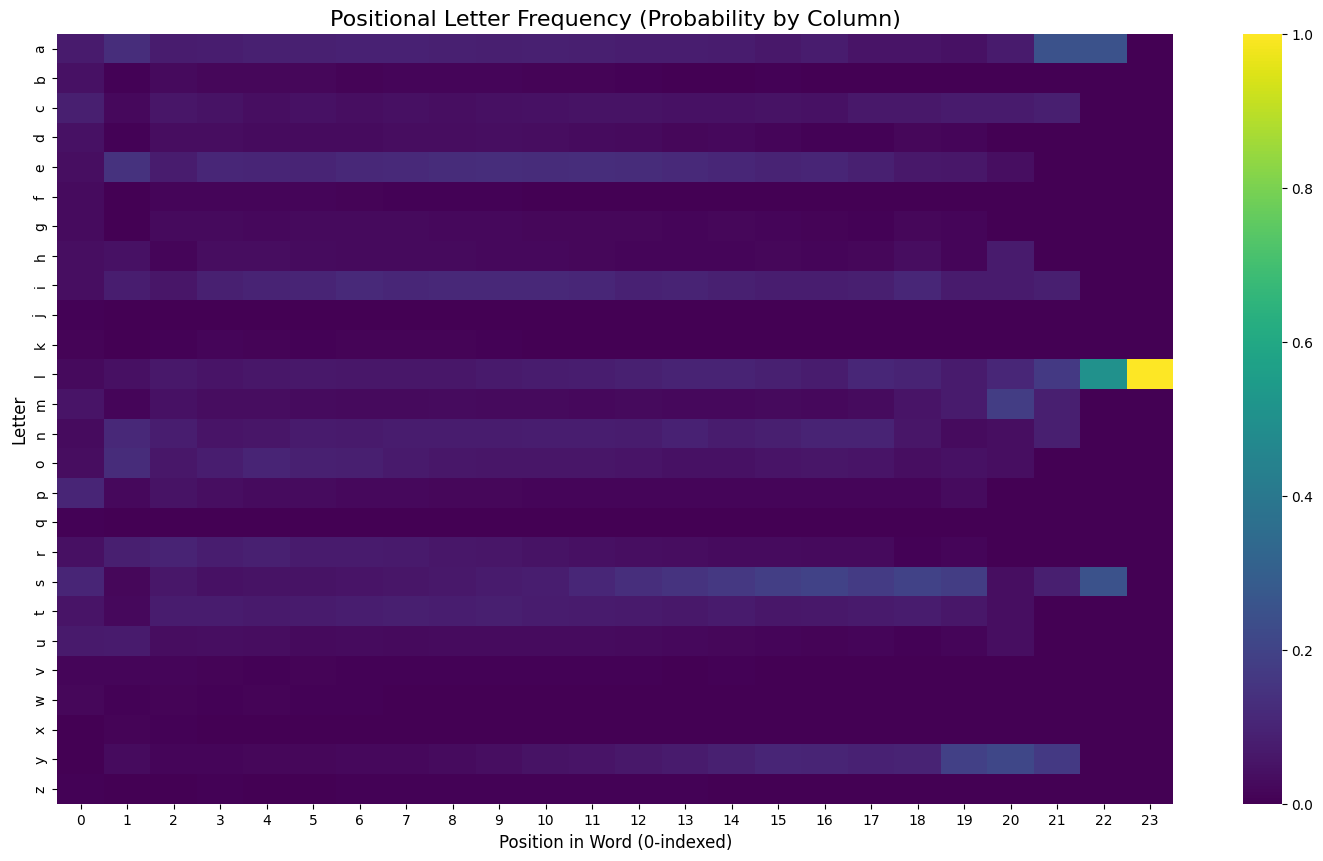

In [2]:
# Cell 2: Exploratory Data Analysis (EDA) - Understanding the Corpus

if 'all_words_by_length' in locals() and all_words_by_length and 'ngram_models' in locals():
    print("\n--- 1. EDA: Word Length Distribution ---")
    
    lengths = sorted(all_words_by_length.keys())
    counts = [len(all_words_by_length[l]) for l in lengths]
    
    plt.figure(figsize=(14, 6))
    plt.bar(lengths, counts, color='teal')
    plt.title('Word Length Distribution in corpus.txt', fontsize=16)
    plt.xlabel('Word Length', fontsize=12)
    plt.ylabel('Number of Words', fontsize=12)
    plt.xticks(lengths[::2])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\n--- 2. EDA: Overall Letter Frequency ---")
    
    unigram_probs = ngram_models['unigrams']
    sorted_probs = sorted(unigram_probs.items(), key=lambda item: item[1], reverse=True)
    
    letters = [item[0] for item in sorted_probs]
    frequencies = [item[1] for item in sorted_probs]

    plt.figure(figsize=(14, 7))
    plt.bar(letters, frequencies, color='skyblue')
    plt.title('Overall Letter Frequency (Probability) in corpus.txt', fontsize=16)
    plt.xlabel('Letter', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.show()

    print("\n--- 3. EDA: Positional Letter Frequency (Heatmap) ---")
    
    max_len = max(len(w) for w in all_words_list)
    
    positional_counts = pd.DataFrame(0, index=list(string.ascii_lowercase), columns=range(max_len))
    
    for word in all_words_list:
        for i, letter in enumerate(word):
            positional_counts.loc[letter, i] += 1
            
    positional_probs = positional_counts.div(positional_counts.sum(axis=0), axis=1)
    positional_probs = positional_probs.fillna(0)

    plt.figure(figsize=(18, 10))
    sns.heatmap(positional_probs, cmap="viridis", annot=False)
    plt.title('Positional Letter Frequency (Probability by Column)', fontsize=16)
    plt.xlabel('Position in Word (0-indexed)', fontsize=12)
    plt.ylabel('Letter', fontsize=12)
    plt.show()
else:
    print("Error: Corpus or N-gram data was not loaded in Cell 1. Cannot run EDA.")

Cell 3: Agent and Environment Definitions (The Model)
This cell defines the core logic: the HMM Oracle, the Hybrid Fallback, the Environment, and the QLearningAgent.

In [3]:
# Cell 3: Hangman Environment and Q-Learning Agent Definitions

def create_regex_pattern(masked_word, guessed_letters):
    """ Creates a regex pattern from the current game state. """
    pattern = ""
    guessed_str = "".join(sorted(list(guessed_letters)))
    if len(guessed_str) == 26: guessed_str = " "
    
    for char in masked_word:
        if char == '_':
            pattern += f"[^{guessed_str}]"
        else:
            pattern += re.escape(char)
    return f"^{pattern}$"

def get_hybrid_fallback_probs(masked_word, guessed_letters, word_list_dict, ngram_models, word_len):
    """ The Hybrid Fallback: Combines N-gram context (70%) with word-length frequency (30%). """
    probabilities = {char: 0.0 for char in ALPHABET}
    
    # --- 1. Get N-gram Probabilities (Contextual Guess) ---
    ngram_votes = defaultdict(float)
    total_ngram_votes = 0
    padded_word = ['#', '#'] + list(masked_word) + ['#']
    
    for i in range(2, len(padded_word)):
        if padded_word[i] == '_':
            p1, p2 = padded_word[i-2], padded_word[i-1]
            if p1 in ngram_models['trigrams'] and p2 in ngram_models['trigrams'][p1]:
                probs = ngram_models['trigrams'][p1][p2]
            elif p2 in ngram_models['bigrams']:
                probs = ngram_models['bigrams'][p2]
            else:
                probs = ngram_models['unigrams']
                
            for char, prob in probs.items():
                if char not in guessed_letters and char != '#':
                    ngram_votes[char] += prob
                    total_ngram_votes += prob

    ngram_probs = {char: 0.0 for char in ALPHABET}
    if total_ngram_votes > 0:
        for char, votes in ngram_votes.items():
            ngram_probs[char] = votes / total_ngram_votes

    # --- 2. Get Word-Length Frequency Probabilities (General Guess) ---
    length_freq_votes = defaultdict(int)
    total_length_freq_votes = 0
    
    for word in word_list_dict.get(word_len, []):
        for char in set(word):
            if char not in guessed_letters:
                length_freq_votes[char] += 1
                total_length_freq_votes += 1

    length_freq_probs = {char: 0.0 for char in ALPHABET}
    if total_length_freq_votes > 0:
        for char, votes in length_freq_votes.items():
            length_freq_probs[char] = votes / total_length_freq_votes

    # --- 3. Combine them with a weighted average (70/30 split) ---
    ngram_weight = 0.7
    length_freq_weight = 0.3
    
    total_prob = 0
    for char in ALPHABET:
        if char not in guessed_letters:
            hybrid_prob = (ngram_probs[char] * ngram_weight) + (length_freq_probs[char] * length_freq_weight)
            probabilities[char] = hybrid_prob
            total_prob += hybrid_prob
            
    # 4. Normalize the final hybrid list
    if total_prob > 0:
        for char in ALPHABET:
            probabilities[char] /= total_prob
    elif total_length_freq_votes == 0 and total_ngram_votes == 0:
        for char, prob in ngram_models['unigrams'].items():
             if char not in guessed_letters:
                probabilities[char] = prob
        
    return probabilities

def get_letter_probabilities(masked_word, guessed_letters, word_list_dict, ngram_models):
    """ The HMM Oracle. Returns (probabilities, confidence_score) """
    word_len = len(masked_word)
    possible_words = word_list_dict.get(word_len, [])
    
    if not possible_words:
        return get_hybrid_fallback_probs(masked_word, guessed_letters, word_list_dict, ngram_models, word_len), 0.0

    pattern_str = create_regex_pattern(masked_word, guessed_letters)
    try:
        pattern = re.compile(pattern_str)
    except re.error:
        pattern = re.compile(f"^{masked_word.replace('_', '.')}$")

    matching_words = [word for word in possible_words if pattern.match(word)]
    
    letter_counts = defaultdict(int)
    total_letters_in_blanks = 0
    blank_indices = [i for i, char in enumerate(masked_word) if char == '_']
    
    for word in matching_words:
        for index in blank_indices:
            letter = word[index]
            if letter not in guessed_letters:
                letter_counts[letter] += 1
                total_letters_in_blanks += 1
                
    if total_letters_in_blanks > 0:
        probabilities = {char: count / total_letters_in_blanks for char, count in letter_counts.items()}
        # Fill in zero probs for unguessed letters not found
        for char in ALPHABET:
            if char not in probabilities and char not in guessed_letters:
                probabilities[char] = 0.0
        return probabilities, 1.0
    else:
        # Fallback to Hybrid N-gram model
        probabilities = get_hybrid_fallback_probs(masked_word, guessed_letters, word_list_dict, ngram_models, word_len)
        return probabilities, 0.0

class HangmanEnvironment:
    """ The environment, now using the confidence-aware state. """
    def __init__(self, word_list_dict, ngram_models):
        self.word_list_dict = word_list_dict
        self.ngram_models = ngram_models
        # ... (initialization logic remains the same) ...
        if not word_list_dict: raise ValueError("Word list is empty.")
        self.all_possible_words = [word for sublist in word_list_dict.values() for word in sublist]
        if not self.all_possible_words: raise ValueError("No valid words loaded.")
        self.lives_allowed = 6
        self.reward_win = 100
        self.reward_lose = -100
        self.reward_wrong_guess = -5
        self.reward_repeated_guess = -2
        self.reward_correct_guess = 5

    def _get_state_and_probs(self):
        """ Returns the new state (including confidence) and probabilities. """
        hmm_probs, confidence = get_letter_probabilities(
            "".join(self.masked_word), self.guessed_letters, self.word_list_dict, self.ngram_models
        )
        num_blanks = "".join(self.masked_word).count('_')
        # State: (lives_left, num_blanks, confidence_flag)
        simple_state = (self.current_lives, num_blanks, int(confidence))
        return simple_state, (hmm_probs, confidence)

    def reset(self, word=None):
        # ... (reset logic remains the same) ...
        if word:
            self.secret_word = word
        else:
            self.secret_word = random.choice(self.all_possible_words)
            
        self.masked_word = ["_"] * len(self.secret_word)
        self.guessed_letters = set()
        self.current_lives = self.lives_allowed
        return self._get_state_and_probs()

    def step(self, action):
        # ... (step logic remains the same) ...
        terminated = False
        reward = 0
        is_repeat = False
        is_correct = False
        is_wrong = False

        if action in self.guessed_letters:
            reward = self.reward_repeated_guess
            is_repeat = True
        else:
            self.guessed_letters.add(action)
            if action in self.secret_word:
                reward = self.reward_correct_guess
                is_correct = True
                for i, letter in enumerate(self.secret_word):
                    if letter == action: self.masked_word[i] = action
            else:
                reward = self.reward_wrong_guess
                self.current_lives -= 1
                is_wrong = True

        if "_" not in self.masked_word:
            terminated = True
            reward += self.reward_win
        elif self.current_lives <= 0:
            terminated = True
            reward += self.reward_lose
            
        (next_state, next_probs_and_confidence) = self._get_state_and_probs()
        
        info = {
            "is_correct": is_correct, "is_repeat": is_repeat, "is_wrong": is_wrong,
            "lives_left": self.current_lives, "masked_word": "".join(self.masked_word)
        }
        return (next_state, next_probs_and_confidence), reward, terminated, info

class QLearningAgent:
    """ The Q-learning agent using the confidence-aware state. """
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=1.0, epsilon_decay=0.999, min_epsilon=0.01):
        # State: (lives_left, num_blanks, confidence)
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0])
        self.num_actions = 3
        
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def choose_action(self, state, probs_and_confidence, guessed_letters):
        """ Chooses an action index (0, 1, or 2) using epsilon-greedy. """
        hmm_probs, confidence = probs_and_confidence
        
        if random.uniform(0, 1) < self.epsilon:
            action_index = random.randint(0, self.num_actions - 1)
        else:
            if not self.q_table[state]:
                action_index = random.randint(0, self.num_actions - 1)
            else:
                action_index = self.q_table[state].index(max(self.q_table[state]))
                
        letter_to_guess = self._map_action_to_letter(action_index, hmm_probs, guessed_letters)
        return action_index, letter_to_guess

    def _map_action_to_letter(self, action_index, hmm_probs, guessed_letters):
        """ Maps the agent's policy (0, 1, 2) to a specific letter guess. """
        sorted_probs = sorted(hmm_probs.items(), key=lambda item: item[1], reverse=True)
        valid_picks = [letter for letter, prob in sorted_probs if letter not in guessed_letters and prob > 0]
        
        guess = None
        if action_index == 0:
            guess = valid_picks[0] if valid_picks else None
        elif action_index == 1:
            guess = valid_picks[1] if len(valid_picks) > 1 else None
        
        if guess is None:
            for letter in GENERIC_LETTERS:
                if letter not in guessed_letters:
                    guess = letter
                    break
        
        if guess is None:
            available = [c for c in ALPHABET if c not in guessed_letters]
            guess = random.choice(available) if available else 'a'
            
        return guess

    def update_q_table(self, state, action_index, reward, next_state):
        """ Updates the Q-table using the Bellman equation. """
        old_value = self.q_table[state][action_index]
        next_max = max(self.q_table[next_state]) if self.q_table[next_state] else 0.0
        new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max)
        self.q_table[state][action_index] = new_value

    def decay_epsilon(self):
        """ Decays the exploration rate. """
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def save_q_table(self, file_path="q_table.pkl"):
        print(f"Saving Q-table to {file_path}...")
        with open(file_path, 'wb') as f:
            pickle.dump(dict(self.q_table), f)
        print("Save complete.")

    def load_q_table(self, file_path="q_table.pkl"):
        try:
            with open(file_path, 'rb') as f:
                self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0], pickle.load(f))
            print(f"Successfully loaded Q-table from {file_path}.")
            self.epsilon = self.min_epsilon
        except FileNotFoundError:
            print(f"No Q-table found at {file_path}. Starting fresh.")
        except Exception as e:
            print(f"Error loading Q-table: {e}. Starting fresh.")

Cell 4: Training and Model Persistence (The Learning)
This cell sets parameters, initializes the agent/environment, runs the training loop, and saves the resulting Q-table.

Starting agent training...
--- Starting Training for 75000 Episodes ---
--- Confidence-aware state is used (Vaccination DISABLED) ---
Episode 1000/75000 | Avg. Reward (1k): 79.92 | Success Rate (1k): 80.2% | Epsilon: 0.9512
Episode 2000/75000 | Avg. Reward (1k): 87.53 | Success Rate (1k): 83.3% | Epsilon: 0.9048
Episode 3000/75000 | Avg. Reward (1k): 87.31 | Success Rate (1k): 83.4% | Epsilon: 0.8607
Episode 4000/75000 | Avg. Reward (1k): 97.15 | Success Rate (1k): 87.6% | Epsilon: 0.8187
Episode 5000/75000 | Avg. Reward (1k): 94.69 | Success Rate (1k): 86.2% | Epsilon: 0.7788
Episode 6000/75000 | Avg. Reward (1k): 99.03 | Success Rate (1k): 88.3% | Epsilon: 0.7408
Episode 7000/75000 | Avg. Reward (1k): 102.92 | Success Rate (1k): 90.0% | Epsilon: 0.7047
Episode 8000/75000 | Avg. Reward (1k): 103.73 | Success Rate (1k): 90.3% | Epsilon: 0.6703
Episode 9000/75000 | Avg. Reward (1k): 106.14 | Success Rate (1k): 91.3% | Epsilon: 0.6376
Episode 10000/75000 | Avg. Reward (1k): 104.11 | Succ

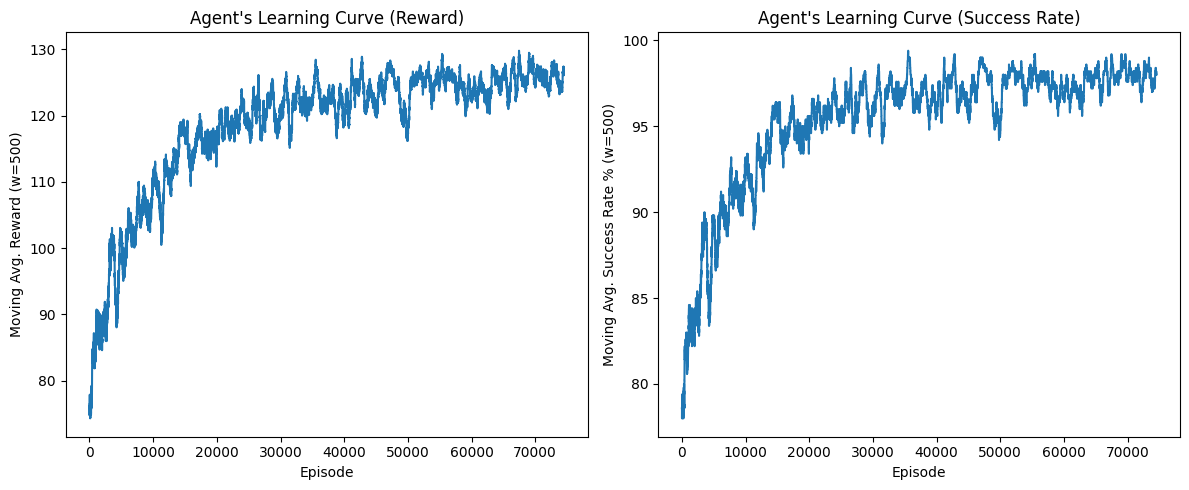

In [4]:
# Cell 4: Training the Agent and Saving the Model

def train(agent, env, num_episodes=75000):
    """ Runs the main training loop for the 'confidence-aware' agent. """
    print(f"--- Starting Training for {num_episodes} Episodes ---")
    print(f"--- Confidence-aware state is used (Vaccination DISABLED) ---")
    start_time = time.time()
    rewards_per_episode = []
    wins_per_episode = [] 

    for episode in range(num_episodes):
        (state, probs_and_confidence) = env.reset()
        terminated = False
        total_reward = 0
        is_win = 0
        
        while not terminated:
            action_index, letter_to_guess = agent.choose_action(
                state, probs_and_confidence, env.guessed_letters
            )
            
            (next_state, next_probs_and_confidence), reward, terminated, info = env.step(letter_to_guess)
            
            agent.update_q_table(state, action_index, reward, next_state)
            
            state = next_state
            probs_and_confidence = next_probs_and_confidence
            total_reward += reward

        # End of episode
        if "_" not in info["masked_word"]: is_win = 1
            
        rewards_per_episode.append(total_reward)
        wins_per_episode.append(is_win)
        agent.decay_epsilon()
        
        # Log progress
        if (episode + 1) % 1000 == 0:
            avg_reward = sum(rewards_per_episode[-1000:]) / 1000
            success_rate_1k = (sum(wins_per_episode[-1000:]) / 1000) * 100
            
            print(f"Episode {episode + 1}/{num_episodes} | Avg. Reward (1k): {avg_reward:.2f} | Success Rate (1k): {success_rate_1k:.1f}% | Epsilon: {agent.epsilon:.4f}")
            
    end_time = time.time()
    print(f"--- Training Complete in {end_time - start_time:.2f} seconds ---")
    return rewards_per_episode, wins_per_episode

# --- Parameters ---
DO_TRAINING = True
LOAD_MODEL = False
NUM_TRAINING_EPISODES = 75000
Q_TABLE_FILE = "my_agent_confidence_strategy.pkl"
epsilon_decay_rate = 0.99995
TEST_FILE = "./data/Data/test.txt"

# 1. Initialize Environment
if 'all_words_by_length' in locals() and all_words_by_length and 'ngram_models' in locals():
    
    env = HangmanEnvironment(all_words_by_length, ngram_models)

    # 2. Initialize Agent
    agent = QLearningAgent(
        learning_rate=0.1, discount_factor=0.99, epsilon=1.0, 
        epsilon_decay=epsilon_decay_rate, min_epsilon=0.01
    )

    # 3. Load or Train
    if LOAD_MODEL:
        print(f"Attempting to load Q-table from {Q_TABLE_FILE}...")
        agent.load_q_table(Q_TABLE_FILE)
    
    if DO_TRAINING:
        print("Starting agent training...")
        rewards, wins = train(agent, env, NUM_TRAINING_EPISODES)
        print(f"Training finished. Saving Q-table as {Q_TABLE_FILE}...")
        agent.save_q_table(Q_TABLE_FILE)
        
        # --- Plotting Training Results ---
        print("Generating learning curve plots...")
        window_size = 500
        if len(rewards) > window_size:
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            avg_rewards = [sum(rewards[i-window_size:i]) / window_size for i in range(window_size, len(rewards))]
            plt.plot(avg_rewards)
            plt.title(f"Agent's Learning Curve (Reward)")
            plt.xlabel("Episode")
            plt.ylabel(f"Moving Avg. Reward (w={window_size})")
            
            plt.subplot(1, 2, 2)
            avg_wins = [(sum(wins[i-window_size:i]) / window_size) * 100 for i in range(window_size, len(wins))]
            plt.plot(avg_wins)
            plt.title(f"Agent's Learning Curve (Success Rate)")
            plt.xlabel("Episode")
            plt.ylabel(f"Moving Avg. Success Rate % (w={window_size})")
            
            plt.tight_layout()
            plt.savefig("reward_plots_confidence_strategy.png")
            print("Saved learning curve plots to reward_plots_confidence_strategy.png")
            plt.show()

    else:
        if not LOAD_MODEL:
            print("Warning: LOAD_MODEL and DO_TRAINING are both False. Agent is untrained.")

else:
    print("Error: Corpus or N-gram data was not loaded. Please check Cell 1.")

Cell 5: Final Evaluation and Demo (The Result)
This final cell runs the crucial evaluation metrics on the test set and provides an optional, detailed single-game demo.

In [5]:
# Cell 5: Final Evaluation and Single Game Demo

def load_test_set(test_file="./data/Data/test.txt"):
    """ Loads and cleans the provided test set file. """
    print(f"Loading test set from {test_file}...")
    test_words = []
    
    try:
        with open(test_file, 'r', encoding='utf-8', errors='ignore') as f:
            words = f.read().split()
    except FileNotFoundError:
        print(f"ERROR: {test_file} not found.")
        return None

    for word in words:
        cleaned_word = word.lower()
        if all(char in ALPHABET for char in cleaned_word) and len(cleaned_word) > 1:
            test_words.append(cleaned_word)
            
    print(f"Loaded {len(test_words)} valid words from {test_file}.")
    return test_words

def evaluate_agent_on_test_file(agent, env, test_word_list):
    """ Evaluates the agent's performance on a specific test set. """
    print(f"\n--- Evaluating Agent on {len(test_word_list)} Games from Test Set ---")
    
    agent.epsilon = 0.0
    wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0
    test_set = test_word_list
    num_games = len(test_set)

    start_time = time.time()
    for i, word in enumerate(test_set):
        
        (state, probs_and_confidence) = env.reset(word=word)
        terminated = False
        wrong_guesses_game = 0
        repeated_guesses_game = 0
        
        while not terminated:
            action_index, letter_to_guess = agent.choose_action(state, probs_and_confidence, env.guessed_letters)
            (next_state, next_probs_and_confidence), reward, terminated, info = env.step(letter_to_guess)
            
            if info["is_wrong"]: wrong_guesses_game += 1
            if info["is_repeat"]: repeated_guesses_game += 1
                
            state = next_state
            probs_and_confidence = next_probs_and_confidence
            
        if "_" not in info["masked_word"]: wins += 1
            
        total_wrong_guesses += wrong_guesses_game
        total_repeated_guesses += repeated_guesses_game

        if (i + 1) % 500 == 0: print(f"Played {i+1}/{num_games} games...")
            
    end_time = time.time()
    print(f"--- Evaluation Complete in {end_time - start_time:.2f} seconds ---")

    # --- Calculate Final Score ---
    success_rate = wins / num_games
    score_from_wins = (success_rate * 2000)
    penalty_wrong = (total_wrong_guesses * 5)
    penalty_repeat = (total_repeated_guesses * 2)
    final_score = score_from_wins - penalty_wrong - penalty_repeat
    
    print("\n" + "="*30)
    print("--- 📊 HACKATHON EVALUATION RESULTS ---")
    print("="*30)
    print(f"Total Games Played: {num_games}")
    print(f"Success Rate: {success_rate * 100:.2f}% ({wins}/{num_games})")
    print(f"Average Wrong Guesses: {total_wrong_guesses/num_games:.2f}")
    print(f"Average Repeated Guesses: {total_repeated_guesses/num_games:.2f}")
    print("---")
    print(f"Total Wrong Guesses: {total_wrong_guesses}")
    print(f"Total Repeated Guesses: {total_repeated_guesses}")
    print("---")
    print(f"Score from Wins: {score_from_wins:.2f}")
    print(f"Penalty from Wrong: -{penalty_wrong}")
    print(f"Penalty from Repeats: -{penalty_repeat}")
    print(f"🏆 FINAL SCORE: {final_score:.2f}")
    print("="*30)

def play_game_inference(agent, env, word_to_play=None):
    """ Plays a single game of Hangman using the trained agent in exploitation-only mode. """
    agent.epsilon = 0.0
    
    try:
        if word_to_play:
            (state, probs_and_confidence) = env.reset(word=word_to_play)
            print(f"--- 🤖 Starting Inference Game with word: {env.secret_word} ---")
        else:
            (state, probs_and_confidence) = env.reset()
            print(f"--- 🤖 Starting Inference Game with random word: {env.secret_word} ---")
    except ValueError as e:
        print(f"Error resetting environment: {e}")
        return

    terminated = False
    all_guesses = []

    print(f"Initial State: {state}")
    print(f"Board: {''.join(env.masked_word)} | Lives: {env.current_lives} | Guessed: []")
    print("-" * 30)
    
    while not terminated:
        action_index, letter_to_guess = agent.choose_action(state, probs_and_confidence, env.guessed_letters)
        (next_state, next_probs_and_confidence), reward, terminated, info = env.step(letter_to_guess)
        
        all_guesses.append(letter_to_guess)
        
        print(f"\nAgent chose strategy: Action {action_index}")
        print(f"Agent guessed: '{letter_to_guess}'")
        
        if info["is_correct"]: print("Result: ✅ CORRECT")
        elif info["is_wrong"]: print("Result: ❌ WRONG")
        elif info["is_repeat"]: print("Result: ⚠️ REPEAT (No change)")
            
        print(f"Board: {info['masked_word']} | Lives: {info['lives_left']} | Guessed: {''.join(sorted(all_guesses))}")
        print(f"New State: {next_state}")
        print("-" * 30)

        state = next_state
        probs_and_confidence = next_probs_and_confidence
        time.sleep(0.75)

    if "_" not in info["masked_word"]: print(f"\n--- 🏆 INFERENCE COMPLETE: AGENT WON! ---")
    else: print(f"\n--- 😥 INFERENCE COMPLETE: AGENT LOST ---")


# --- Execute Evaluation and Demo ---
if 'agent' in locals() and 'env' in locals():
    # 4. Load the Test Set
    test_word_list = load_test_set(TEST_FILE)

    # 5. Evaluate
    if test_word_list:
        evaluate_agent_on_test_file(agent, env, test_word_list)
    else:
        print(f"Could not load test set from {TEST_FILE}. Skipping evaluation.")
        
    # --- Demo ---
    print("\n\n" + "="*40)
    print("--- PLAYING A SINGLE DEMO GAME (RANDOM WORD) ---")
    print("="*40)
    play_game_inference(agent, env)
    
else:
    print("Error: 'agent' and 'env' variables not found. Please run Cell 4 first.")

Loading test set from ./data/Data/test.txt...
Loaded 2000 valid words from ./data/Data/test.txt.

--- Evaluating Agent on 2000 Games from Test Set ---
Played 500/2000 games...
Played 1000/2000 games...
Played 1500/2000 games...
Played 2000/2000 games...
--- Evaluation Complete in 121.45 seconds ---

--- 📊 HACKATHON EVALUATION RESULTS ---
Total Games Played: 2000
Success Rate: 32.15% (643/2000)
Average Wrong Guesses: 5.23
Average Repeated Guesses: 0.00
---
Total Wrong Guesses: 10464
Total Repeated Guesses: 0
---
Score from Wins: 643.00
Penalty from Wrong: -52320
Penalty from Repeats: -0
🏆 FINAL SCORE: -51677.00


--- PLAYING A SINGLE DEMO GAME (RANDOM WORD) ---
--- 🤖 Starting Inference Game with random word: slang ---
Initial State: (6, 5, 1)
Board: _____ | Lives: 6 | Guessed: []
------------------------------

Agent chose strategy: Action 0
Agent guessed: 'a'
Result: ✅ CORRECT
Board: __a__ | Lives: 6 | Guessed: a
New State: (6, 4, 1)
------------------------------

Agent chose strategy